### References
- https://arxiv.org/pdf/1905.01164
- https://github.com/tamarott/SinGAN

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import math
import torch
from torch import nn
from torchvision.transforms import v2 as T
from torchvision.io import read_image
from tqdm import tqdm
import numpy as np
import imageio

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_IMAGE_CH = 3
KERNEL_SIZE = 3 
STRIDE = 1
PADDING = 0
N_LAYERS = 5
ALPHA = 10
BETA_1, BETA_2 = 0.5, 0.999
LR_D, LR_G = 0.0005, 0.0005
D_STEPS, G_STEPS = 3, 1
LAMBDA = 0.1
SCALE_FACTOR = 0.7919
MAX_FC = 128
MIN_FC = 32
MIN_WIDTH, MIN_HEWIGHT = 32, 32

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class ConvBlock(nn.Sequential):
    def __init__(self, in_channel, out_channel, kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING):
        super().__init__()
        self.add_module('Conv', nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding))
        self.add_module('BatchNorm', nn.BatchNorm2d(out_channel))
        self.add_module('LeakyReLU', nn.LeakyReLU(0.2, inplace=True))
        

class Discriminator(nn.Module):
    def __init__(self, n_i_ch, n_f_ch):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(n_i_ch, n_f_ch),
            ConvBlock(n_f_ch, n_f_ch),
            ConvBlock(n_f_ch, n_f_ch),
            ConvBlock(n_f_ch, n_f_ch),
            nn.Conv2d(n_f_ch, 1, KERNEL_SIZE, STRIDE, PADDING)
        )

    def forward(self, x):
        return self.layers(x)


class Generator(nn.Module):
    def __init__(self, n_i_ch, n_f_ch):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(n_i_ch, n_f_ch),
            ConvBlock(n_f_ch, n_f_ch),
            ConvBlock(n_f_ch, n_f_ch),
            ConvBlock(n_f_ch, n_f_ch),
            nn.Conv2d(n_f_ch, n_i_ch, KERNEL_SIZE, STRIDE, PADDING),
            nn.Tanh()
        )

    def forward(self, z, img):
        x = self.layers(z + img.detach())
        ind = int((img.shape[2] - x.shape[2]) / 2)
        img = img[:, :, ind:(img.shape[2] - ind), ind:(img.shape[3] - ind)]
        return x+img


def init_models(n_i_ch, n_f_ch):
    G = Generator(n_i_ch, n_f_ch).to(DEVICE)
    G.apply(weights_init)
    
    D = Discriminator(n_i_ch, n_f_ch).to(DEVICE)
    D.apply(weights_init)

    return G, D

In [4]:
def generate_noise(size):
    noise = torch.randn(*size, device=DEVICE)
    return noise


def get_padding():
    return int(((KERNEL_SIZE - 1) * N_LAYERS) / 2)


def gen_pyramidic_prev_fake_image(gens, zs_rec, reals, noise_amps, m_image, m_noise, reconstruction_noise_mode=True):
    _, _, nzx, nzy = reals[0].shape
    prev_fake = torch.full([1, N_IMAGE_CH, nzx, nzy], 0, device=DEVICE)
    if len(gens) > 0:
        for G, z_rec, curr_real, next_real, noise_amp in zip(gens, zs_rec, reals, reals[1:], noise_amps):
            prev_fake = prev_fake[:, :, 0:curr_real.shape[2], 0:curr_real.shape[3]]
            prev_fake = m_image(prev_fake)

            if reconstruction_noise_mode:
                z = z_rec
            else:
                pad_noise = get_padding()
                z = generate_noise([1, N_IMAGE_CH, z_rec.shape[2] - 2 * pad_noise, z_rec.shape[3] - 2 * pad_noise])
                z = m_noise(z)

            z_in = noise_amp * z
            prev_fake = G(z_in.detach(), prev_fake)

            # upscaling fake image
            w, h = next_real.shape[-2], next_real.shape[-1]
            prev_fake = T.Resize((w, h))(prev_fake)

    return prev_fake


def creat_reals_pyramid(real, count):
    reals = []
    for i in range(0, count + 1):
        scale = math.pow(SCALE_FACTOR, count - i)
        w, h = round(real.shape[-2] * scale), round(real.shape[-1] * scale)
        w, h = max(MIN_WIDTH, w), max(MIN_HEWIGHT, h)
        curr_real = T.Resize((w, h))(real / 255)
        reals.append(curr_real.unsqueeze(0))
    return reals


def reset_grads(model, require_grad):
    for p in model.parameters():
        p.requires_grad_(require_grad)
    return model


def compute_gradient_penalty(D, real, fake):
    alpha = torch.rand(1, 1)
    alpha = alpha.expand(real.size())
    alpha = alpha.to(DEVICE)
    interpolates = alpha * real + ((1 - alpha) * fake)

    interpolates = interpolates.to(DEVICE)
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    d_interpolates = D(interpolates)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(DEVICE),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [5]:
# prepare data
img = read_image('planets\\black_hole\\354557101.png')
img = T.Resize((128, 128))(img)
img = img[0:3, :, :]
n_scale = 7
reals = creat_reals_pyramid(img, n_scale)
gens, noise_amps = [], []

# prepare reconstruction noise
zs_rec = []
for i in range(n_scale + 1):
    pad_noise = get_padding()
    m_noise = nn.ZeroPad2d(int(pad_noise))
    shape = reals[i].shape
    if i == 0:
        z_rec = generate_noise(shape)
    else:
        z_rec = torch.full(shape, 0, device=DEVICE)
    z_rec = m_noise(z_rec)
    zs_rec.append(z_rec)

Start train at scale: 0


  0%|          | 0/2001 [00:00<?, ?it/s]

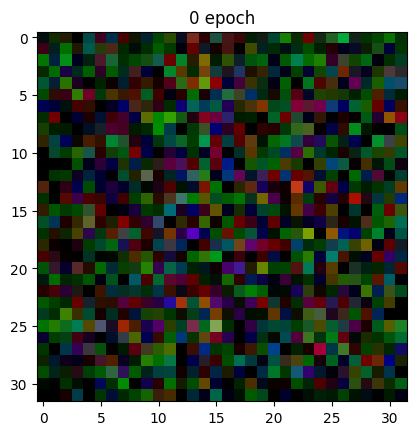

 25%|██▍       | 498/2001 [00:23<01:08, 21.86it/s]

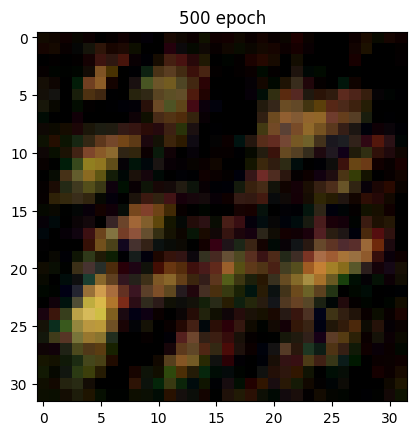

 50%|████▉     | 999/2001 [00:47<00:45, 21.96it/s]

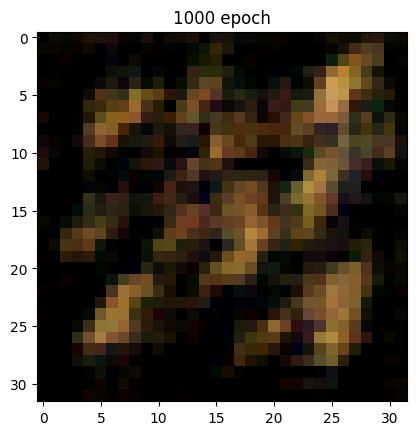

 75%|███████▍  | 1499/2001 [01:10<00:22, 22.02it/s]

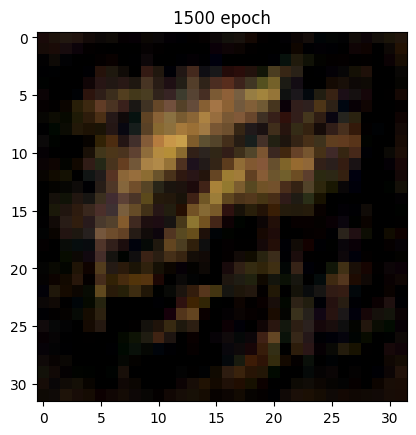

100%|█████████▉| 1999/2001 [01:34<00:00, 21.40it/s]

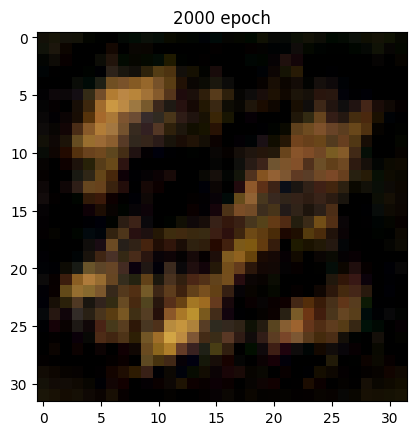

100%|██████████| 2001/2001 [01:34<00:00, 21.18it/s]


Start train at scale: 1


  0%|          | 0/2001 [00:00<?, ?it/s]

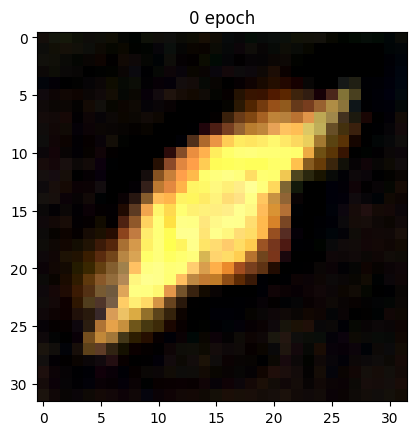

 25%|██▍       | 499/2001 [00:24<01:12, 20.68it/s]

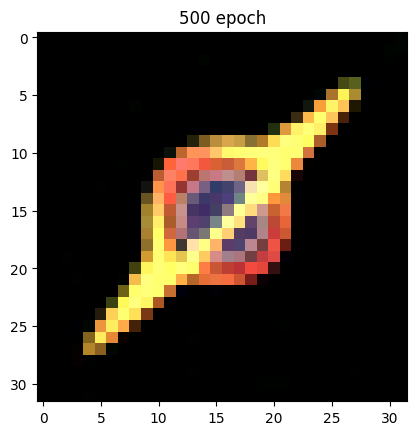

 50%|████▉     | 1000/2001 [00:49<00:50, 19.65it/s]

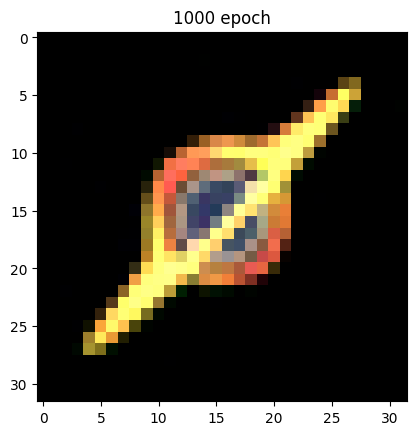

 75%|███████▍  | 1500/2001 [01:15<00:25, 19.90it/s]

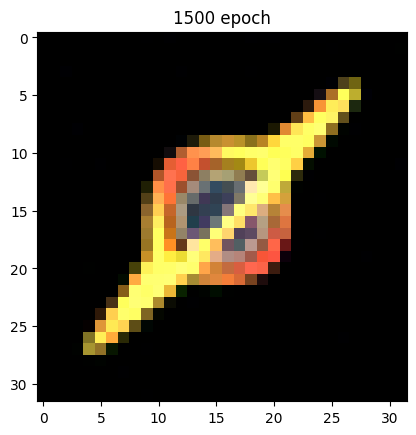

100%|█████████▉| 1999/2001 [01:40<00:00, 20.17it/s]

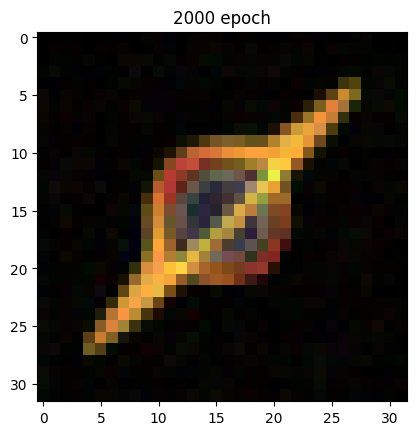

100%|██████████| 2001/2001 [01:40<00:00, 19.91it/s]


Start train at scale: 2


  0%|          | 0/2001 [00:00<?, ?it/s]

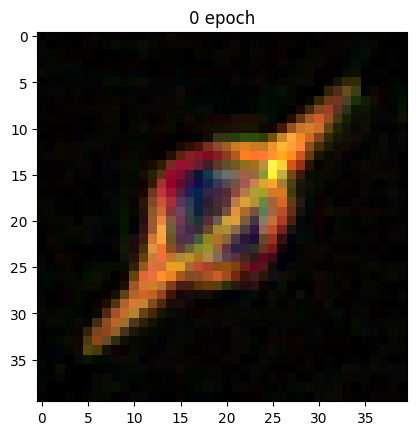

 25%|██▍       | 499/2001 [00:27<01:20, 18.77it/s]

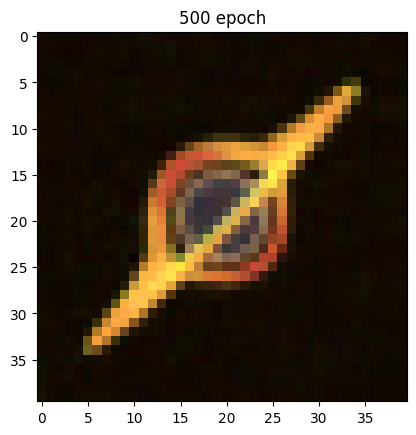

 50%|████▉     | 999/2001 [00:53<00:53, 18.80it/s]

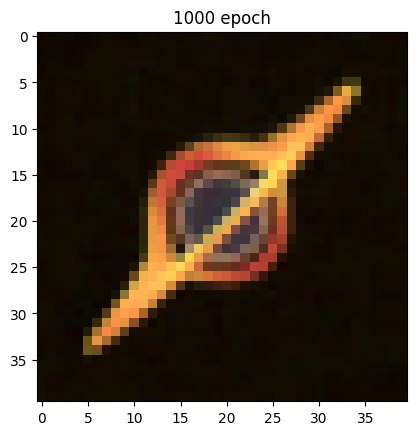

 75%|███████▍  | 1499/2001 [01:20<00:26, 18.73it/s]

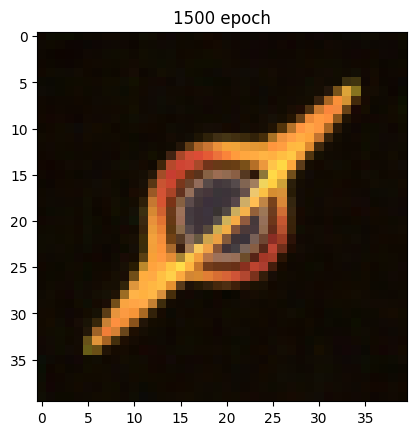

100%|█████████▉| 1999/2001 [01:47<00:00, 18.68it/s]

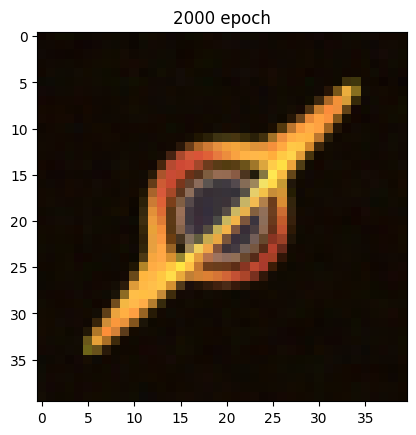

100%|██████████| 2001/2001 [01:47<00:00, 18.56it/s]


Start train at scale: 3


  0%|          | 0/2001 [00:00<?, ?it/s]

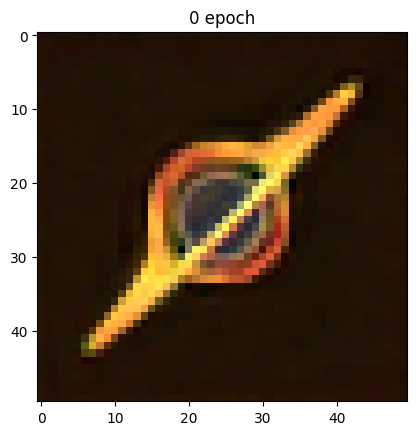

 25%|██▍       | 499/2001 [00:28<01:24, 17.86it/s]

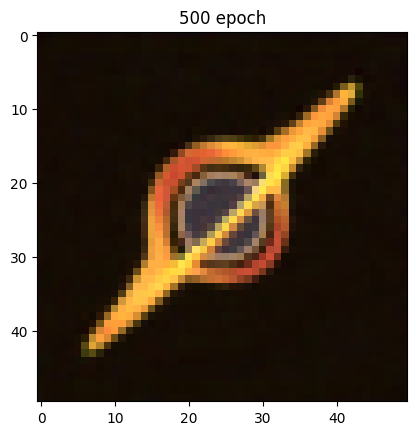

 50%|████▉     | 999/2001 [00:56<00:56, 17.85it/s]

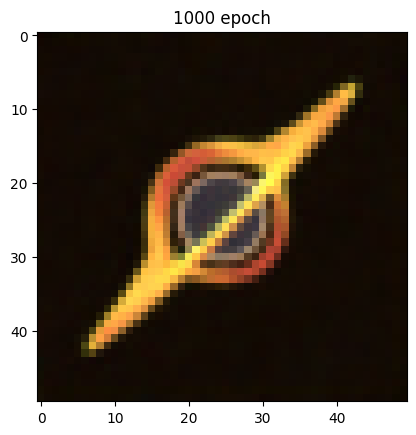

 75%|███████▍  | 1499/2001 [01:24<00:28, 17.81it/s]

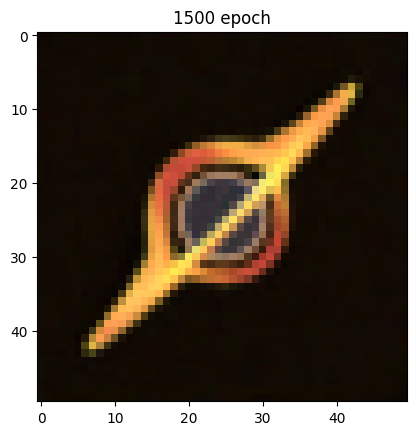

100%|█████████▉| 1999/2001 [01:52<00:00, 17.70it/s]

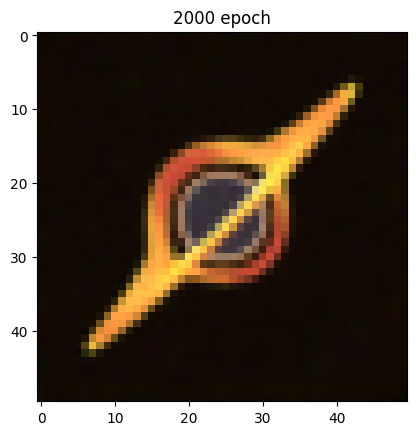

100%|██████████| 2001/2001 [01:52<00:00, 17.73it/s]


Start train at scale: 4


  0%|          | 0/2001 [00:00<?, ?it/s]

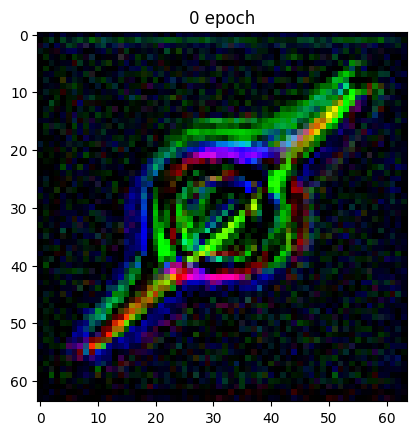

 25%|██▍       | 499/2001 [00:29<01:29, 16.81it/s]

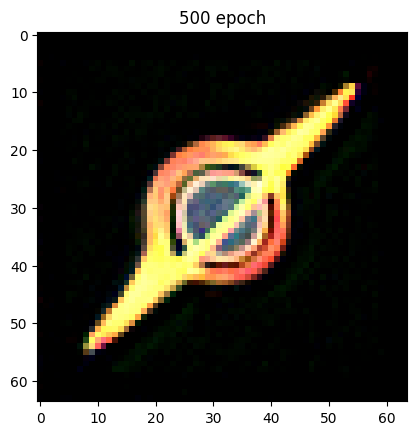

 50%|████▉     | 999/2001 [00:59<00:59, 16.78it/s]

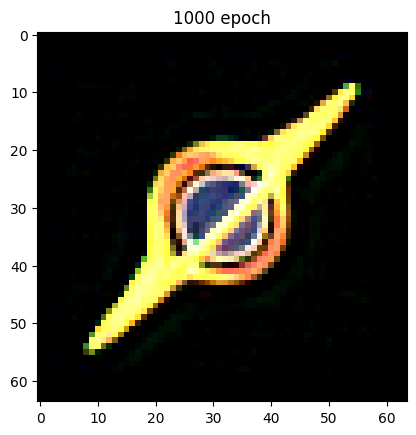

 75%|███████▍  | 1499/2001 [01:29<00:29, 17.20it/s]

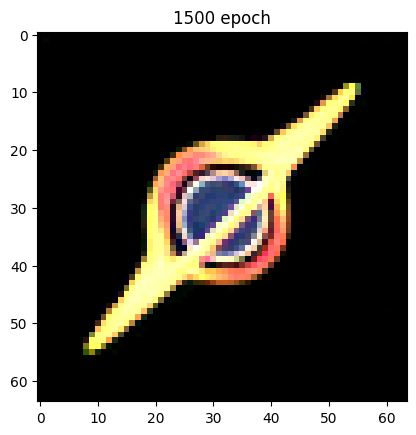

100%|█████████▉| 1999/2001 [01:59<00:00, 17.19it/s]

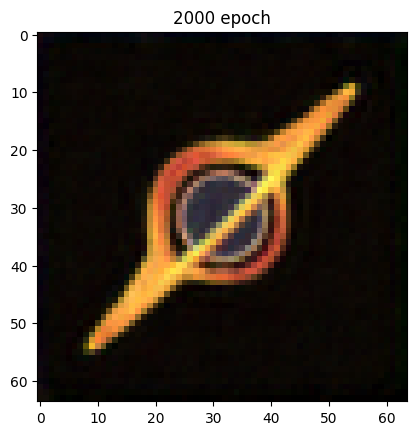

100%|██████████| 2001/2001 [01:59<00:00, 16.77it/s]


Start train at scale: 5


  0%|          | 0/2001 [00:00<?, ?it/s]

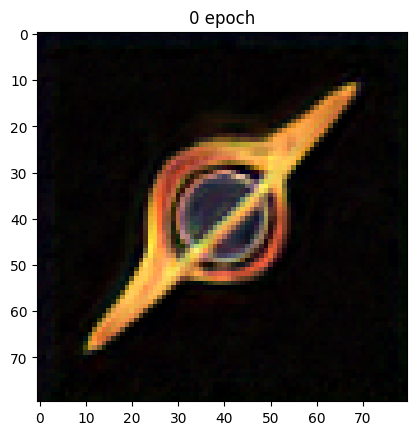

 25%|██▍       | 500/2001 [00:53<02:35,  9.62it/s]

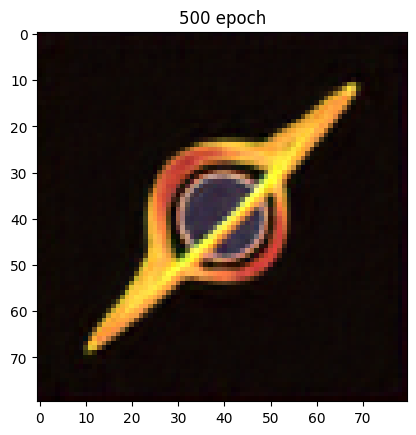

 50%|████▉     | 1000/2001 [01:46<01:48,  9.23it/s]

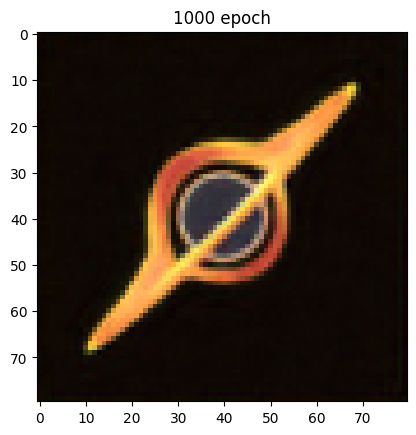

 75%|███████▍  | 1500/2001 [02:39<00:52,  9.50it/s]

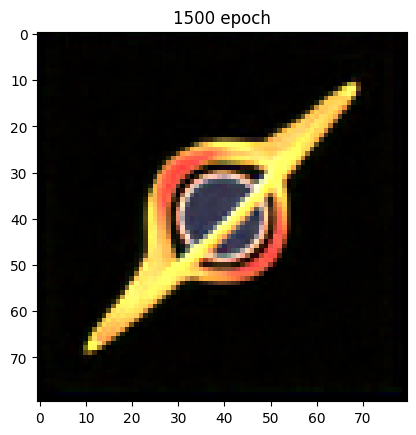

100%|█████████▉| 2000/2001 [03:32<00:00,  9.66it/s]

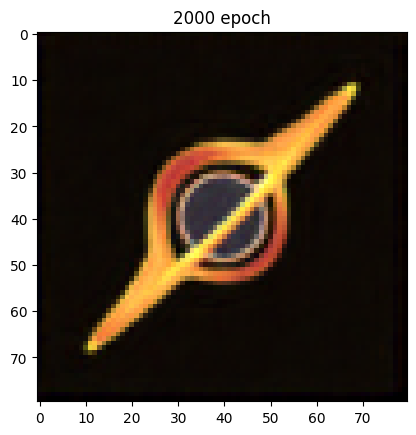

100%|██████████| 2001/2001 [03:32<00:00,  9.42it/s]


Start train at scale: 6


  0%|          | 0/2001 [00:00<?, ?it/s]

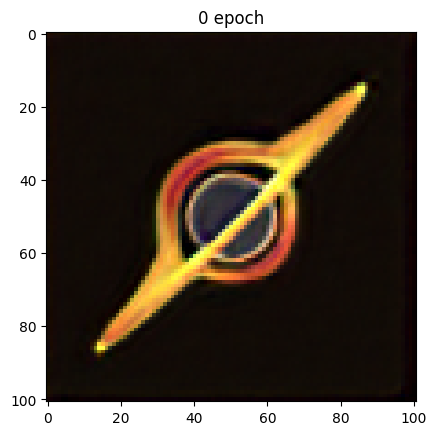

 25%|██▍       | 500/2001 [01:01<03:07,  8.02it/s]

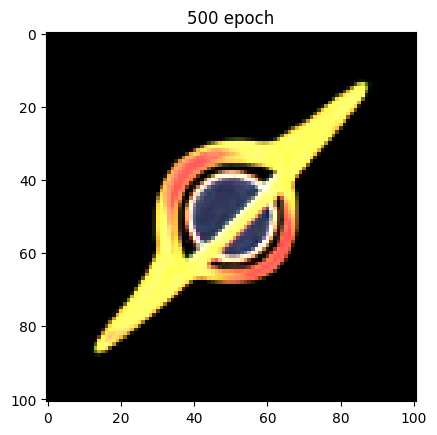

 50%|████▉     | 1000/2001 [02:03<01:58,  8.41it/s]

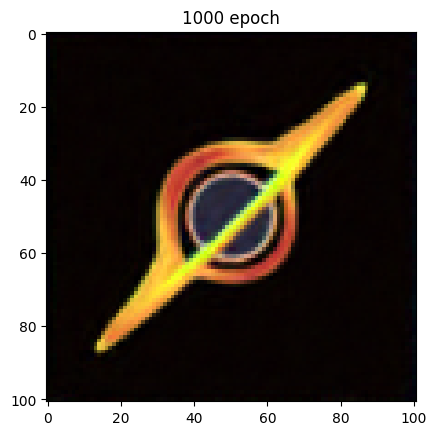

 75%|███████▍  | 1500/2001 [03:04<00:59,  8.46it/s]

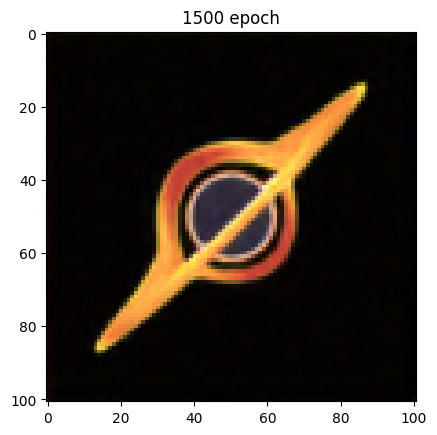

100%|█████████▉| 2000/2001 [04:04<00:00,  8.38it/s]

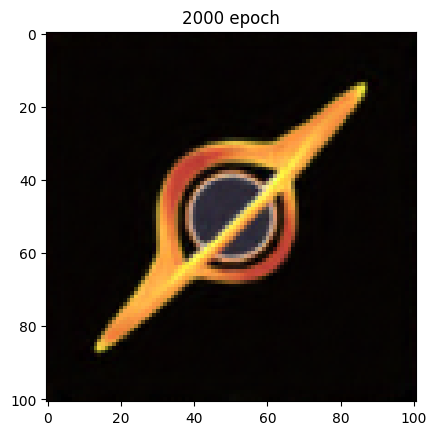

100%|██████████| 2001/2001 [04:04<00:00,  8.19it/s]


Start train at scale: 7


  0%|          | 0/2001 [00:00<?, ?it/s]

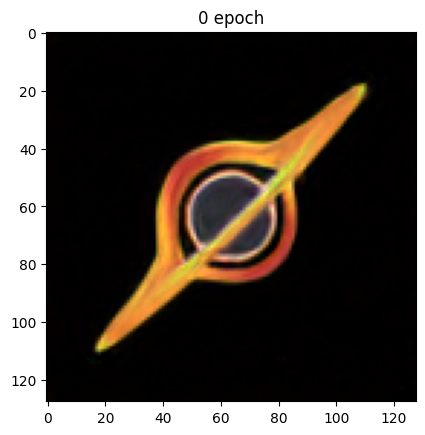

 25%|██▍       | 500/2001 [01:16<03:55,  6.36it/s]

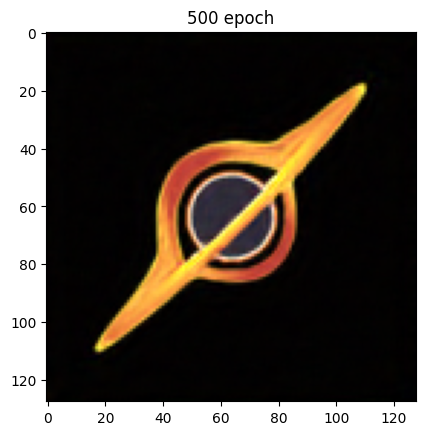

 50%|████▉     | 1000/2001 [02:38<02:54,  5.75it/s]

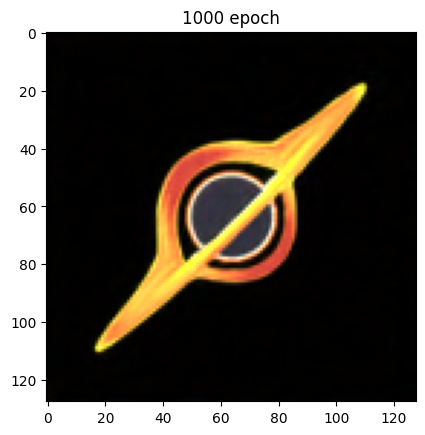

 75%|███████▍  | 1500/2001 [04:02<01:25,  5.87it/s]

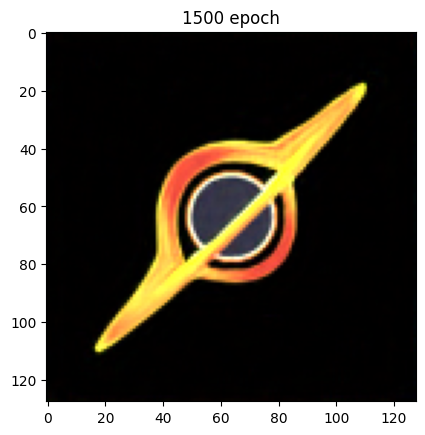

100%|█████████▉| 2000/2001 [05:25<00:00,  6.11it/s]

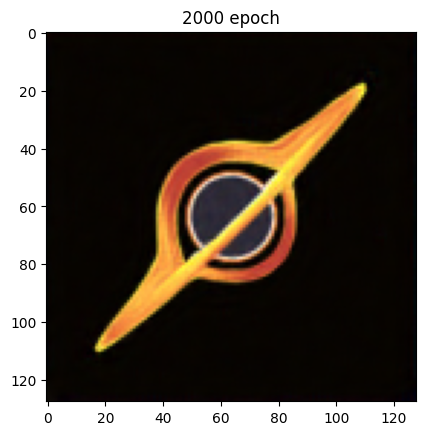

100%|██████████| 2001/2001 [05:26<00:00,  6.13it/s]


In [6]:
def train():
    noise_amp = 0

    init_n_f_ch = MIN_FC
    prev_n_f_ch = None

    for scale in range(n_scale + 1):
        print('Start train at scale:', scale)
        n_f_ch = min(init_n_f_ch * pow(2, math.floor(scale / 4)), MAX_FC)
        G, D = init_models(N_IMAGE_CH, n_f_ch)
        G.train()
        D.train()

        # loading a saved model
        if (prev_n_f_ch == n_f_ch):
            G.load_state_dict(torch.load(f'save/{n_f_ch}-{scale-1}-G.pth'))
            D.load_state_dict(torch.load(f'save/{n_f_ch}-{scale-1}-D.pth'))

        # model training
        G, noise_amp = train_single(G, D, zs_rec, reals, noise_amp)

        # saving model
        torch.save(G.state_dict(), f'save/{n_f_ch}-{scale}-G.pth')
        torch.save(D.state_dict(), f'save/{n_f_ch}-{scale}-D.pth')

        G = reset_grads(G, False)
        G.eval()

        gens.append(G)
        noise_amps.append(noise_amp)

        prev_n_f_ch = n_f_ch
        del D, G


def train_single(G, D, zs_rec, reals, noise_amp):
    # setup optimizer
    optimizerD = torch.optim.Adam(D.parameters(), lr=LR_D, betas=(BETA_1, BETA_2))
    optimizerG = torch.optim.Adam(G.parameters(), lr=LR_G, betas=(BETA_1, BETA_2))
    schedulerD = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerD, milestones=[1600], gamma=0.1)
    schedulerG = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerG, milestones=[1600], gamma=0.1)

    real = reals[len(gens)]
    real = real.to(DEVICE)

    z_rec = zs_rec[len(gens)]

    nzx = real.shape[2]
    nzy = real.shape[3]

    pad_noise = pad_image = get_padding()

    m_noise = nn.ZeroPad2d(int(pad_noise))
    m_image = nn.ZeroPad2d(int(pad_image))

    mse_loss = nn.MSELoss()

    for epoch in tqdm(range(2001)):
        z = generate_noise((1, N_IMAGE_CH, nzx, nzy))
        z = m_noise(z)

        # update D
        for j in range(D_STEPS):
            # train with real
            D.zero_grad()
            output = D(real).to(DEVICE)
            errD_real = -output.mean()
            errD_real.backward(retain_graph=True)

            # train with fake
            if j == 0 and epoch == 0:
                if gens == []:
                    prev_fake = torch.full([1, N_IMAGE_CH, nzx, nzy], 0, device=DEVICE)
                    prev_fake = m_image(prev_fake)
                    prev_rec_fake = torch.full([1, N_IMAGE_CH, nzx, nzy], 0, device=DEVICE)
                    prev_rec_fake = m_noise(prev_rec_fake)
                    noise_amp = 1
                else:
                    prev_fake = gen_pyramidic_prev_fake_image(gens, zs_rec, reals, noise_amps, m_image, m_noise)
                    prev_fake = m_image(prev_fake)
                    prev_rec_fake = gen_pyramidic_prev_fake_image(gens, zs_rec, reals, noise_amps, m_image, m_noise, reconstruction_noise_mode=False)
                    RMSE = torch.sqrt(mse_loss(real, prev_rec_fake))
                    noise_amp = 0.1 * RMSE
                    prev_rec_fake = m_noise(prev_rec_fake)
            else:
                prev_fake = gen_pyramidic_prev_fake_image(gens, zs_rec, reals, noise_amps, m_image, m_noise)
                prev_fake = m_image(prev_fake)

            if gens == []:
                z_in = z
            else:
                z_in = noise_amp * z

            fake = G(z_in.detach(), prev_fake)
            output = D(fake.detach())
            errD_fake = output.mean()
            errD_fake.backward(retain_graph=True)

            gradient_penalty = compute_gradient_penalty(D, real, fake)
            gradient_penalty.backward()

            optimizerD.step()

        # update G
        for _ in range(G_STEPS):
            G.zero_grad()
            output = D(fake)
            errG = -output.mean()
            errG.backward(retain_graph=True)

            z_rec_ = noise_amp * z_rec
            rec_loss = ALPHA * mse_loss(G(z_rec_.detach(), prev_rec_fake), real)
            rec_loss.backward(retain_graph=True)

            optimizerG.step()

        if epoch % 500 == 0:
            plt.imshow(fake.clamp(0, 1).squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
            plt.title(f'{epoch} epoch')
            plt.show()

        schedulerD.step()
        schedulerG.step()

    return G, noise_amp


train()

In [7]:
def generate_gif(gens, zs_rec, noise_amps, alpha=0.1, beta=0.9, start_scale=2, fps=10):
    z = torch.full(zs_rec[0].shape, 0, device=DEVICE)
    images_cur = []

    for count, vals in enumerate(zip(gens, zs_rec, noise_amps)):
        G, z_rec, noise_amp = vals
        padding = get_padding()
        mask = nn.ZeroPad2d(int(padding))

        images_prev = images_cur
        images_cur = []

        z_rand = generate_noise(z_rec.shape)
        z_prev_1 = 0.95 * z_rec + 0.05 * z_rand
        z_prev_2 = z_rec

        for i in range(0, 100):
            z_rand = generate_noise(z_rec.shape)
            diff_curr = beta * (z_prev_1 - z_prev_2) + (1 - beta) * z_rand

            z_curr = alpha * z_rec + (1 - alpha) * (z_prev_1 + diff_curr)
            z_prev_2 = z_prev_1
            z_prev_1 = z_curr

            if images_prev == []:
                prev_image = z
            else:
                prev_image = images_prev[i]
                w, h = z_rec.shape[2] - padding * 2, z_rec.shape[3] - padding * 2
                prev_image = T.Resize((w, h))(prev_image)
                prev_image = mask(prev_image)
            
            if count < start_scale:
                z_curr = z_rec
            
            z_in = noise_amp * z_curr
            generated = G(z_in, prev_image)

            images_cur.append(generated)
        
    prepared_imgs = []
    for img in images_cur:
        img = img.squeeze(0).permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()
        img = (img * 255).astype(np.uint8)
        prepared_imgs.append(img)
        
    imageio.mimsave(f'scale-{start_scale}-alpha-{alpha}-beta-{beta}.gif', prepared_imgs, fps=fps)
    return images_cur

In [8]:
for start_scale in range(0, 2, 1):
    for b in range(60, 100, 5):
        for a in range(0, 20, 5):
            generate_gif(gens, zs_rec, noise_amps, beta=b/100, alpha=a/100, start_scale=start_scale)

In [9]:
def generate(gens, zs_rec, noise_amps, injection=None, n=0, gen_start_scale=0):
    images_prev = []
    for G, z_rec, noise_amp in zip(gens, zs_rec, noise_amps):
        padding = get_padding()
        mask = nn.ZeroPad2d(int(padding))
        nzx = int((z_rec.shape[2] - padding * 2))
        nzy = int((z_rec.shape[3] - padding * 2))

        # generate noise or use reconstruction noise
        if n < gen_start_scale:
            z = z_rec
        else:
            z = generate_noise([1, N_IMAGE_CH, nzx, nzy])
            z = mask(z)

        # prepare previous image
        if images_prev == []:
            # get zeros if injection image is none
            if injection is None:
                injection = torch.full([1, N_IMAGE_CH, nzx, nzy], 0, device=DEVICE)
            prev = mask(injection)
        else:
            prev = images_prev[-1]
            w, h = z.shape[-2] - padding * 2, z.shape[-1] - padding * 2
            prev = T.Resize((w, h))(prev)
            prev = mask(prev)

        z_in = noise_amp*(z)
        generated = G(z_in.detach(), prev)
        images_prev.append(generated)
        n += 1
    return generated.detach()


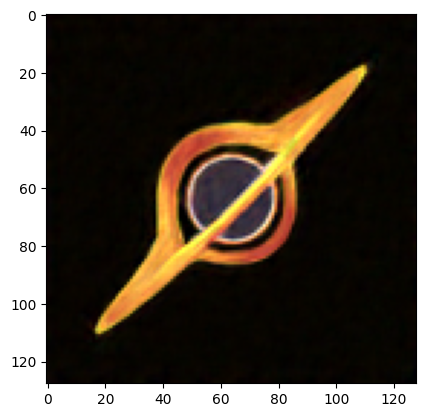

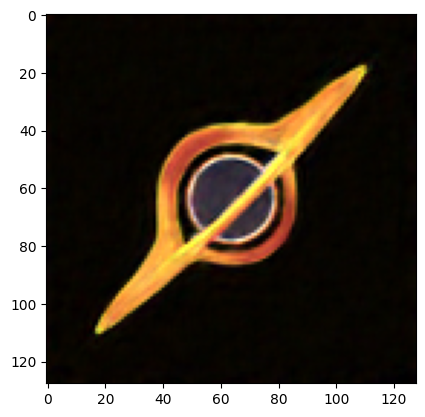

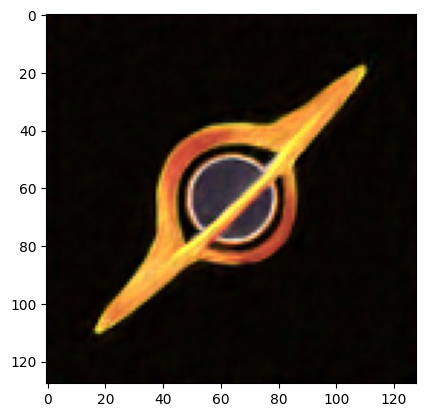

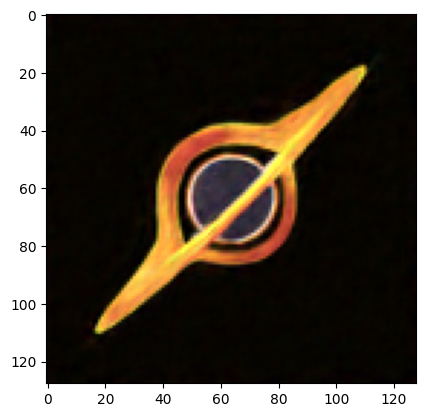

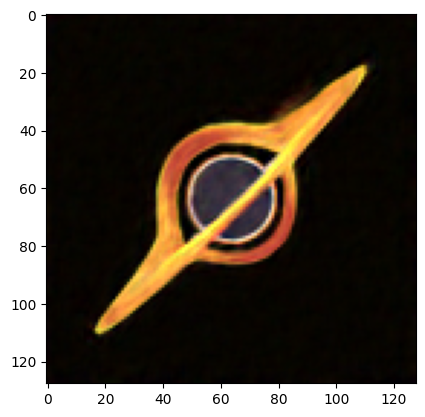

In [10]:
for _ in range(5):
    img = generate(gens[0:], zs_rec[0:], noise_amps[0:], n=0, gen_start_scale=1)
    plt.imshow(img.clamp(0, 1).squeeze(0).permute(1, 2, 0).cpu())
    plt.show()